In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load datasets
df = pd.read_csv('data/Case2_Sales data.csv', delimiter=';', header=0, encoding="utf-8")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        9802 non-null   object
 1   Mapped_GCK  9802 non-null   object
 2   Sales_EUR   9802 non-null   object
dtypes: object(3)
memory usage: 229.9+ KB


In [3]:
# Read the CSV file, skipping the first two rows and setting the correct header
file_path = "data/Case2_Market data.csv"  # Adjust path if needed
market_data = pd.read_csv(file_path, delimiter=';', skiprows=2, header=0, encoding="utf-8", decimal=",")
 
# Display basic info
market_data.info()

# Show first few rows
market_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    219 non-null    object 
 1   MAB_ELE_PRO156          219 non-null    int64  
 2   MAB_ELE_SHP156          219 non-null    int64  
 3   MAB_ELE_PRO250          219 non-null    int64  
 4   MAB_ELE_SHP250          219 non-null    int64  
 5   MAB_ELE_PRO276          219 non-null    int64  
 6   MAB_ELE_SHP276          219 non-null    int64  
 7   MAB_ELE_PRO380          219 non-null    int64  
 8   MAB_ELE_SHP380          219 non-null    int64  
 9   MAB_ELE_PRO392          219 non-null    int64  
 10  MAB_ELE_SHP392          219 non-null    int64  
 11  MAB_ELE_PRO756          218 non-null    float64
 12  MAB_ELE_SHP756          218 non-null    float64
 13  MAB_ELE_PRO826          219 non-null    int64  
 14  MAB_ELE_SHP826          201 non-null    fl

,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,...,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51
0,2004m2,17,17,112,83,83,79,124,87,109,...,81.0,121,142,106,102,86,NaN,NaN,NaN,NaN
1,2004m3,24,24,136,106,101,97,143,106,141,...,77.0,138,153,140,117,98,NaN,NaN,NaN,NaN
2,2004m4,24,24,118,92,90,85,129,96,106,...,72.0,116,138,106,105,87,NaN,NaN,NaN,NaN
3,2004m5,24,24,109,86,87,82,136,100,102,...,66.0,119,144,102,97,85,NaN,NaN,NaN,NaN
4,2004m6,27,27,134,107,99,95,136,111,120,...,61.0,129,144,117,118,95,NaN,NaN,NaN,NaN


In [4]:
# Drop completely empty columns
market_data = market_data.drop(columns=["Unnamed: 48", "Unnamed: 49", "Unnamed: 50", "Unnamed: 51"])

# Verify that the columns are removed
market_data.info()

# Show first few rows
market_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    219 non-null    object 
 1   MAB_ELE_PRO156          219 non-null    int64  
 2   MAB_ELE_SHP156          219 non-null    int64  
 3   MAB_ELE_PRO250          219 non-null    int64  
 4   MAB_ELE_SHP250          219 non-null    int64  
 5   MAB_ELE_PRO276          219 non-null    int64  
 6   MAB_ELE_SHP276          219 non-null    int64  
 7   MAB_ELE_PRO380          219 non-null    int64  
 8   MAB_ELE_SHP380          219 non-null    int64  
 9   MAB_ELE_PRO392          219 non-null    int64  
 10  MAB_ELE_SHP392          219 non-null    int64  
 11  MAB_ELE_PRO756          218 non-null    float64
 12  MAB_ELE_SHP756          218 non-null    float64
 13  MAB_ELE_PRO826          219 non-null    int64  
 14  MAB_ELE_SHP826          201 non-null    fl

,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,...,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
0,2004m2,17,17,112,83,83,79,124,87,109,...,118,81,118,NaN,81.0,121,142,106,102,86
1,2004m3,24,24,136,106,101,97,143,106,141,...,148,102,119,NaN,77.0,138,153,140,117,98
2,2004m4,24,24,118,92,90,85,129,96,106,...,125,91,117,NaN,72.0,116,138,106,105,87
3,2004m5,24,24,109,86,87,82,136,100,102,...,117,88,118,NaN,66.0,119,144,102,97,85
4,2004m6,27,27,134,107,99,95,136,111,120,...,143,101,119,NaN,61.0,129,144,117,118,95


In [5]:
test_template = pd.read_csv('data/Case2_Test Set Template.csv')
test_template.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 1 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Month Year;Mapped_GCK;Sales_EUR  140 non-null    object
dtypes: object(1)
memory usage: 1.2+ KB


In [6]:
# Display basic info
print("Sales Data:")
print(df.info())
print(df.head())

print("\nMarket Data:")
print(market_data.info())
print(market_data.head())

print("\nTest Set Template:")
print(test_template.info())
print(test_template.head())

Sales Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   DATE        9802 non-null   object
 1   Mapped_GCK  9802 non-null   object
 2   Sales_EUR   9802 non-null   object
dtypes: object(3)
memory usage: 229.9+ KB
None
         DATE Mapped_GCK Sales_EUR
0  01.10.2018         #1         0
1  02.10.2018         #1         0
2  03.10.2018         #1         0
3  04.10.2018         #1         0
4  05.10.2018         #1         0

Market Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    219 non-null    object 
 1   MAB_ELE_PRO156          219 non-null    int64  
 2   MAB_ELE_SHP156          219 non-null    int64  
 3   MAB_ELE_PRO250          219 non-null

In [7]:
market_data['date'] = pd.to_datetime(market_data['date'].str.extract(r'(\d{4})m(\d+)').agg('-'.join, axis=1), format='%Y-%m')

In [8]:
market_data.head()

,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,...,PRO28250_org,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org
0,2004-02-01,17,17,112,83,83,79,124,87,109,...,118,81,118,NaN,81.0,121,142,106,102,86
1,2004-03-01,24,24,136,106,101,97,143,106,141,...,148,102,119,NaN,77.0,138,153,140,117,98
2,2004-04-01,24,24,118,92,90,85,129,96,106,...,125,91,117,NaN,72.0,116,138,106,105,87
3,2004-05-01,24,24,109,86,87,82,136,100,102,...,117,88,118,NaN,66.0,119,144,102,97,85
4,2004-06-01,27,27,134,107,99,95,136,111,120,...,143,101,119,NaN,61.0,129,144,117,118,95


In [9]:
market_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    219 non-null    datetime64[ns]
 1   MAB_ELE_PRO156          219 non-null    int64         
 2   MAB_ELE_SHP156          219 non-null    int64         
 3   MAB_ELE_PRO250          219 non-null    int64         
 4   MAB_ELE_SHP250          219 non-null    int64         
 5   MAB_ELE_PRO276          219 non-null    int64         
 6   MAB_ELE_SHP276          219 non-null    int64         
 7   MAB_ELE_PRO380          219 non-null    int64         
 8   MAB_ELE_SHP380          219 non-null    int64         
 9   MAB_ELE_PRO392          219 non-null    int64         
 10  MAB_ELE_SHP392          219 non-null    int64         
 11  MAB_ELE_PRO756          218 non-null    float64       
 12  MAB_ELE_SHP756          218 non-null    float64   

In [10]:
# Convert DATE columns to datetime format
df['DATE'] = pd.to_datetime(df['DATE'], dayfirst=True)
#market_data['DATE'] = pd.to_datetime(market_data['DATE'])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        9802 non-null   datetime64[ns]
 1   Mapped_GCK  9802 non-null   object        
 2   Sales_EUR   9802 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 229.9+ KB


In [12]:
# Aggregate daily sales to monthly sales
df['YearMonth'] = df['DATE'].dt.to_period('M')
monthly_sales = df.groupby(['YearMonth', 'Mapped_GCK'])['Sales_EUR'].sum().reset_index()
monthly_sales['YearMonth'] = monthly_sales['YearMonth'].astype(str)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        9802 non-null   datetime64[ns]
 1   Mapped_GCK  9802 non-null   object        
 2   Sales_EUR   9802 non-null   object        
 3   YearMonth   9802 non-null   period[M]     
dtypes: datetime64[ns](1), object(2), period[M](1)
memory usage: 306.4+ KB


In [14]:
df.head(3)

,DATE,Mapped_GCK,Sales_EUR,YearMonth
0,2018-10-01,#1,0,2018-10
1,2018-10-02,#1,0,2018-10
2,2018-10-03,#1,0,2018-10


In [15]:
# Aggregate market data to monthly level
market_data['YearMonth'] = market_data['date'].dt.to_period('M')
monthly_market = market_data.groupby('YearMonth').mean().reset_index()
monthly_market['YearMonth'] = monthly_market['YearMonth'].astype(str)

In [16]:
market_data.info()
market_data.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 49 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    219 non-null    datetime64[ns]
 1   MAB_ELE_PRO156          219 non-null    int64         
 2   MAB_ELE_SHP156          219 non-null    int64         
 3   MAB_ELE_PRO250          219 non-null    int64         
 4   MAB_ELE_SHP250          219 non-null    int64         
 5   MAB_ELE_PRO276          219 non-null    int64         
 6   MAB_ELE_SHP276          219 non-null    int64         
 7   MAB_ELE_PRO380          219 non-null    int64         
 8   MAB_ELE_SHP380          219 non-null    int64         
 9   MAB_ELE_PRO392          219 non-null    int64         
 10  MAB_ELE_SHP392          219 non-null    int64         
 11  MAB_ELE_PRO756          218 non-null    float64       
 12  MAB_ELE_SHP756          218 non-null    float64   

,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,MAB_ELE_PRO380,MAB_ELE_SHP380,MAB_ELE_PRO392,...,PRO28276_org,PRO27840_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27380_org,PRO27392_org,PRO27250_org,PRO27276_org,YearMonth
0,2004-02-01,17,17,112,83,83,79,124,87,109,...,81,118,NaN,81.0,121,142,106,102,86,2004-02
1,2004-03-01,24,24,136,106,101,97,143,106,141,...,102,119,NaN,77.0,138,153,140,117,98,2004-03
2,2004-04-01,24,24,118,92,90,85,129,96,106,...,91,117,NaN,72.0,116,138,106,105,87,2004-04


In [24]:
monthly_market['YearMonth'] = (pd.to_datetime(monthly_market['YearMonth']) - pd.DateOffset(years=1)).dt.to_period('M').astype(str)
# Merge sales with market data
final_data = monthly_market.merge(monthly_sales, left_on='YearMonth', right_on='YearMonth', how='left')

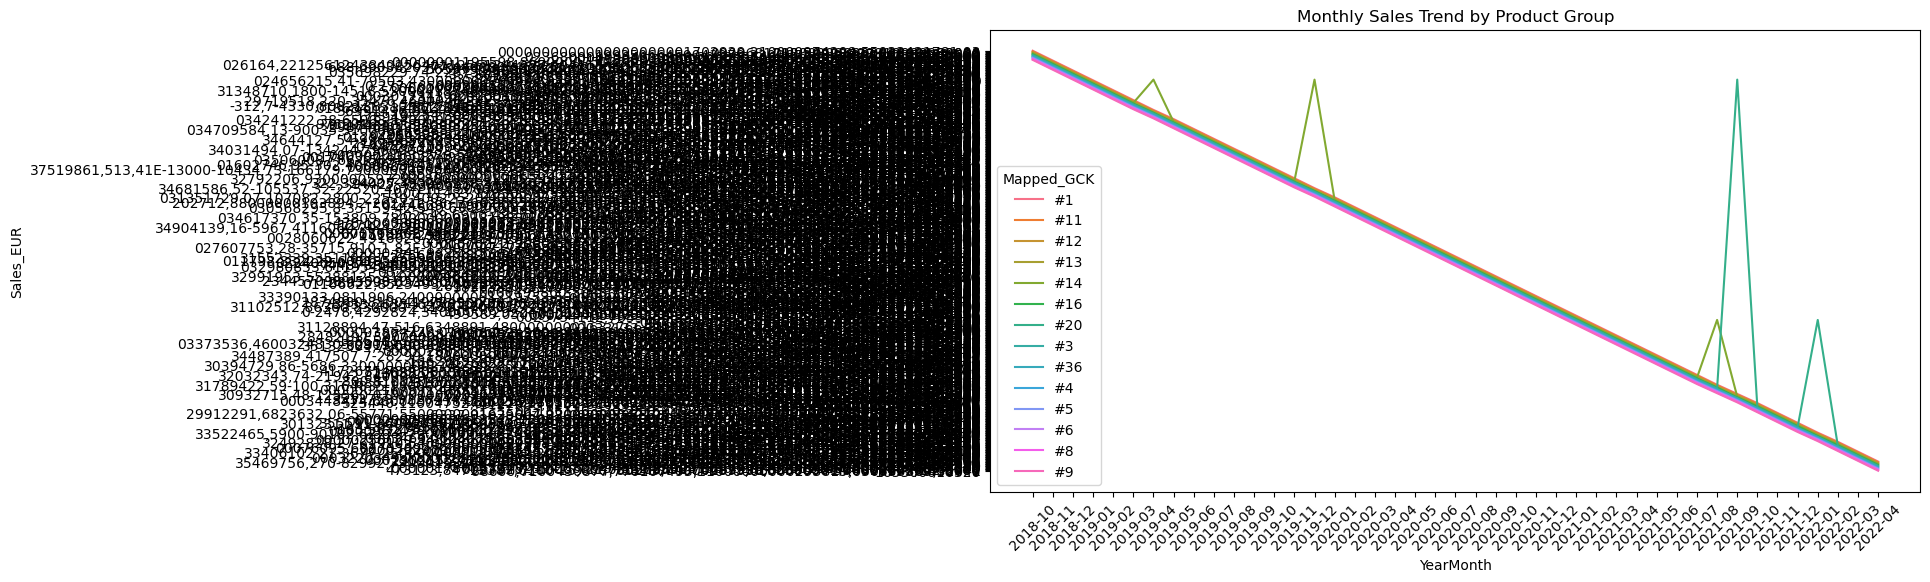

In [18]:
# Visualization of sales trends
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x='YearMonth', y='Sales_EUR', hue='Mapped_GCK')
plt.xticks(rotation=45)
plt.title('Monthly Sales Trend by Product Group')
plt.show()

In [25]:
# --- Feature Engineering ---
final_data['Year'] = final_data['YearMonth'].str[:4].astype(int)
final_data['Month'] = final_data['YearMonth'].str[-2:].astype(int)

# Ensure numeric conversion for merged dataset
final_data['Sales_EUR'] = pd.to_numeric(final_data['Sales_EUR'], errors='coerce')
final_data.fillna(0, inplace=True)

for lag in [1, 3, 6]:
    final_data[f'Sales_Lag_{lag}'] = final_data.groupby('Mapped_GCK')['Sales_EUR'].shift(lag)

final_data['Sales_Rolling_3'] = final_data.groupby('Mapped_GCK')['Sales_EUR'].rolling(window=3, min_periods=1).mean().reset_index(0, drop=True)
final_data['Sales_Rolling_6'] = final_data.groupby('Mapped_GCK')['Sales_EUR'].rolling(window=6, min_periods=1).mean().reset_index(0, drop=True)

final_data.fillna(method='bfill', inplace=True)

In [27]:
# --- Train-Test Split ---
train_data = final_data[final_data['YearMonth'] < '2022-05']
test_data = final_data[final_data['YearMonth'] >= '2022-05']

# Drop non-numeric columns
X_train = train_data.drop(columns=['Sales_EUR', 'YearMonth', 'Mapped_GCK']).select_dtypes(include=[np.number])
y_train = train_data['Sales_EUR']
X_test = test_data.drop(columns=['Sales_EUR', 'YearMonth', 'Mapped_GCK']).select_dtypes(include=[np.number])
y_test = test_data['Sales_EUR']

In [ ]:
test_data

,YearMonth,Mapped_GCK,Sales_EUR,date,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_PRO250,MAB_ELE_SHP250,MAB_ELE_PRO276,MAB_ELE_SHP276,...,PRO27392_org,PRO27250_org,PRO27276_org,Year,Month,Sales_Lag_1,Sales_Lag_3,Sales_Lag_6,Sales_Rolling_3,Sales_Rolling_6


In [28]:
# Ensure no NaN or Inf values in training data
X_train = X_train.replace([np.inf, -np.inf], np.nan).dropna()
X_train = X_train.astype(np.float32)
X_train.dropna(inplace=True)
X_train.replace([np.inf, -np.inf], 0, inplace=True)
X_test.fillna(0, inplace=True)
X_test.replace([np.inf, -np.inf], 0, inplace=True)

In [29]:
# --- Train Random Forest Model ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Ensure X_test and y_test are not empty
if not X_test.empty and not y_test.empty:
	rf_model.fit(X_train, y_train)
	y_pred_rf = rf_model.predict(X_test)
	rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
	print(f'Random Forest RMSE: {rmse_rf}')
else:
	print("X_test or y_test is empty. Cannot train or predict.")

X_test or y_test is empty. Cannot train or predict.


In [22]:
# --- Train XGBoost Model ---
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

if not X_test.empty and not y_test.empty:
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

    print(f'XGBoost RMSE: {rmse_xgb}')
	  
else:
	print("X_test or y_test is empty. Cannot train or predict.")

NameError: name 'X_test' is not defined

In [ ]:
# --- Train Exponential Smoothing Model ---
es_model = ExponentialSmoothing(train_data['Sales_EUR'], seasonal='add', seasonal_periods=12).fit()
y_pred_es = es_model.forecast(len(test_data))
rmse_es = np.sqrt(mean_squared_error(y_test, y_pred_es))
print(f'Exponential Smoothing RMSE: {rmse_es}')

In [ ]:
# --- Model Comparison ---
rmse_results = pd.DataFrame({'Model': ['Random Forest', 'XGBoost', 'Exponential Smoothing'],
                             'RMSE': [rmse_rf, rmse_xgb, rmse_es]})
print(rmse_results.sort_values(by='RMSE'))

In [ ]:
# --- Forecasting & Submission ---
best_model = xgb_model if rmse_xgb < rmse_rf and rmse_xgb < rmse_es else rf_model if rmse_rf < rmse_es else es_model
test_template['Sales_EUR'] = best_model.predict(X_test) if best_model != es_model else y_pred_es
test_template.to_csv('/mnt/data/final_submission.csv', index=False)